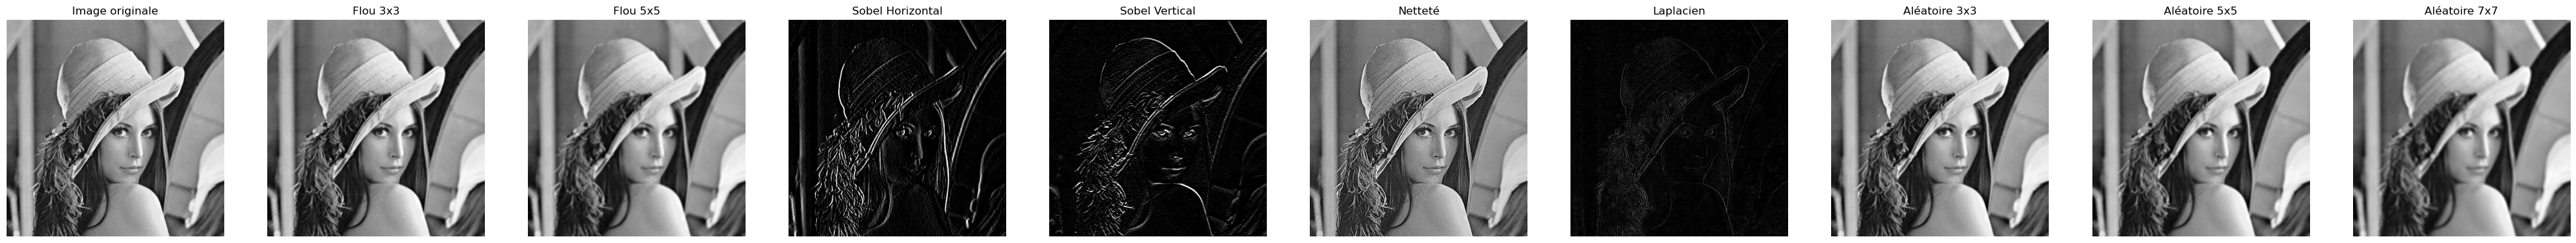

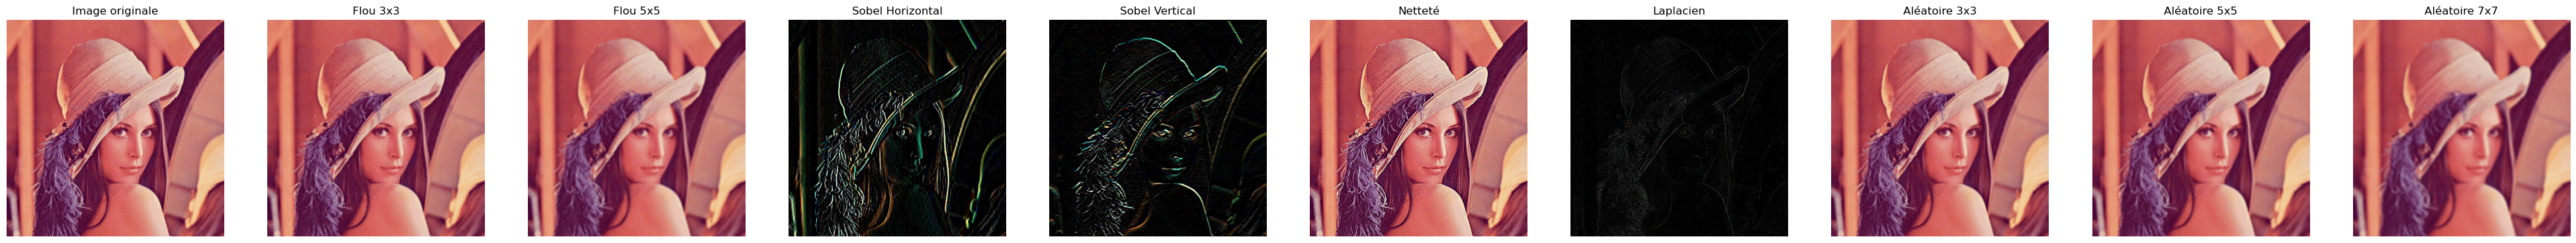

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Fonction pour charger une image (grayscale ou RGB)
def image_load(image_path, channel):
    """Charge une image en niveaux de gris ou RGB."""
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas"
    if channel == 1:  # Grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        assert img is not None, "Erreur : Impossible de charger l'image en niveaux de gris"
        assert len(img.shape) == 2, "L'image doit être en niveaux de gris (2D)"
    elif channel == 3:  # RGB
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        assert img is not None, "Erreur : Impossible de charger l'image RGB"
        assert len(img.shape) == 3 and img.shape[2] == 3, "L'image RGB doit avoir 3 canaux"
    else:
        raise ValueError("Channel doit être 1 (grayscale) ou 3 (RGB)")
    return img

# Fonction pour appliquer la convolution sur un canal
def convolve_channel(image, kernel):
    """Applique la convolution à un canal d'image."""
    # Assertions pour valider les dimensions
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy"
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy"
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D"
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré"
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire"
    assert image.shape[0] >= kernel.shape[0], "L'image est trop petite pour le noyau en hauteur"
    assert image.shape[1] >= kernel.shape[1], "L'image est trop petite pour le noyau en largeur"
    
    # Dimensions
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height, pad_width = kernel_height // 2, kernel_width // 2
    
    # Ajouter un padding (testé avec différents modes)
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='reflect')
    
    # Vérifier la taille de la sortie
    output = np.zeros_like(image, dtype=np.float32)
    assert output.shape == image.shape, "La taille de la sortie doit correspondre à l'image d'entrée"
    
    # Appliquer la convolution
    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            output[i, j] = np.sum(region * kernel)
    
    return output

# Fonction pour appliquer la convolution sur une image (grayscale ou RGB)
def apply_convolution(image, kernel):
    """Applique un filtre de convolution à une image."""
    # Assertions pour valider les entrées
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy"
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy"
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D"
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré"
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire"
    assert len(image.shape) in [2, 3], "L'image doit être en niveaux de gris (2D) ou RGB (3D)"
    
    if len(image.shape) == 3:  # Image RGB
        assert image.shape[2] == 3, "L'image RGB doit avoir 3 canaux"
        height, width, channels = image.shape
        output = np.zeros_like(image, dtype=np.float32)
        for c in range(channels):
            output[:, :, c] = convolve_channel(image[:, :, c], kernel)
    else:  # Image grayscale
        output = convolve_channel(image, kernel)
    
    # Normaliser pour éviter des valeurs hors plage [0, 255]
    output = np.clip(output, 0, 255)
    assert output.shape == image.shape, "La taille de la sortie doit correspondre à l'image d'entrée"
    return output.astype(np.uint8)

# Fonction pour afficher plusieurs images filtrées
def display_images(original, filtered_list, titles, save_path=None):
    """Affiche l'image originale et les images filtrées dans une seule figure."""
    n = len(filtered_list) + 1
    plt.figure(figsize=(5 * n, 5))
    
    # Afficher l'image originale
    plt.subplot(1, n, 1)
    plt.title("Image originale")
    plt.imshow(original, cmap='gray' if len(original.shape) == 2 else None)
    plt.axis('off')
    
    # Afficher les images filtrées
    for i, (filtered, title) in enumerate(zip(filtered_list, titles), 2):
        plt.subplot(1, n, i)
        plt.title(title)
        plt.imshow(filtered, cmap='gray' if len(filtered.shape) == 2 else None)
        plt.axis('off')
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Définir les filtres
def get_kernels():
    """Retourne une liste de noyaux de convolution, y compris ceux de Wikipédia et aléatoires."""
    kernels = {}
    titles = {}
    
    # 1. Filtre de flou (moyenne) 3x3
    kernels['blur_3x3'] = np.array([[1/9, 1/9, 1/9],
                                    [1/9, 1/9, 1/9],
                                    [1/9, 1/9, 1/9]])
    titles['blur_3x3'] = "Flou 3x3"
    
    # 2. Filtre de flou 5x5
    kernels['blur_5x5'] = np.ones((5, 5)) / 25
    titles['blur_5x5'] = "Flou 5x5"
    
    # 3. Filtre Sobel horizontal
    kernels['sobel_horizontal'] = np.array([[-1, 0, 1],
                                            [-2, 0, 2],
                                            [-1, 0, 1]])
    titles['sobel_horizontal'] = "Sobel Horizontal"
    
    # 4. Filtre Sobel vertical
    kernels['sobel_vertical'] = np.array([[-1, -2, -1],
                                          [0, 0, 0],
                                          [1, 2, 1]])
    titles['sobel_vertical'] = "Sobel Vertical"
    
    # 5. Filtre de netteté (sharpen)
    kernels['sharpen'] = np.array([[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]])
    titles['sharpen'] = "Netteté"
    
    # 6. Filtre Laplacien (détection de contours)
    kernels['laplacian'] = np.array([[0, 1, 0],
                                     [1, -4, 1],
                                     [0, 1, 0]])
    titles['laplacian'] = "Laplacien"
    
    # 7. Filtre aléatoire 3x3
    np.random.seed(42)  # Pour reproductibilité
    random_3x3 = np.random.rand(3, 3)
    random_3x3 = random_3x3 / np.sum(random_3x3)  # Normalisation
    kernels['random_3x3'] = random_3x3
    titles['random_3x3'] = "Aléatoire 3x3"
    
    # 8. Filtre aléatoire 5x5
    np.random.seed(42)
    random_5x5 = np.random.rand(5, 5)
    random_5x5 = random_5x5 / np.sum(random_5x5)
    kernels['random_5x5'] = random_5x5
    titles['random_5x5'] = "Aléatoire 5x5"
    
    # 9. Filtre aléatoire 7x7
    np.random.seed(42)
    random_7x7 = np.random.rand(7, 7)
    random_7x7 = random_7x7 / np.sum(random_7x7)
    kernels['random_7x7'] = random_7x7
    titles['random_7x7'] = "Aléatoire 7x7"
    
    return kernels, titles

# Fonction principale
def main():
    # Chemin de l'image  
    image_path = r'C:\Users\user\Desktop\lenna.jpeg'   
    output_dir = 'filtered_images'
    os.makedirs(output_dir, exist_ok=True)
    
    # Charger les images
    gray_image = image_load(image_path, 1)
    rgb_image = image_load(image_path, 3)
    
    # Obtenir les noyaux et titres
    kernels, titles = get_kernels()
    
    # Appliquer les filtres sur l'image grayscale
    gray_filtered = {name: apply_convolution(gray_image, kernel) for name, kernel in kernels.items()}
    
    # Appliquer les filtres sur l'image RGB
    rgb_filtered = {name: apply_convolution(rgb_image, kernel) for name, kernel in kernels.items()}
    
    # Afficher les résultats
    display_images(gray_image, list(gray_filtered.values()), list(titles.values()), 
                   save_path=os.path.join(output_dir, 'gray_filtered.png'))
    display_images(rgb_image, list(rgb_filtered.values()), list(titles.values()), 
                   save_path=os.path.join(output_dir, 'rgb_filtered.png'))
    
    # Sauvegarder les images filtrées
    for name, filtered in gray_filtered.items():
        cv2.imwrite(os.path.join(output_dir, f'{name}_gray.jpg'), filtered)
    for name, filtered in rgb_filtered.items():
        filtered_bgr = cv2.cvtColor(filtered, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(output_dir, f'{name}_rgb.jpg'), filtered_bgr)

if __name__ == "__main__":
    main()

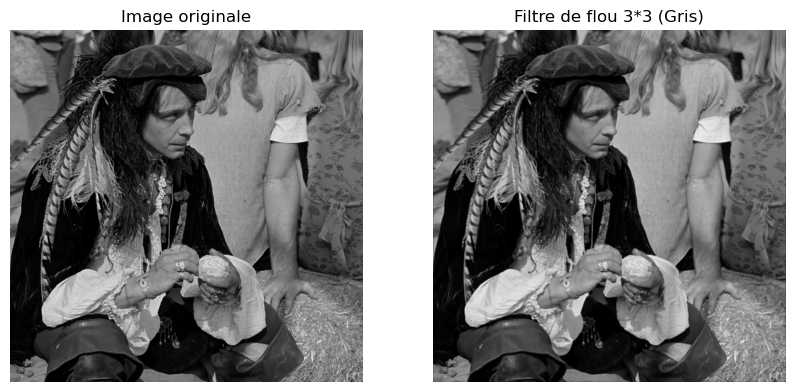

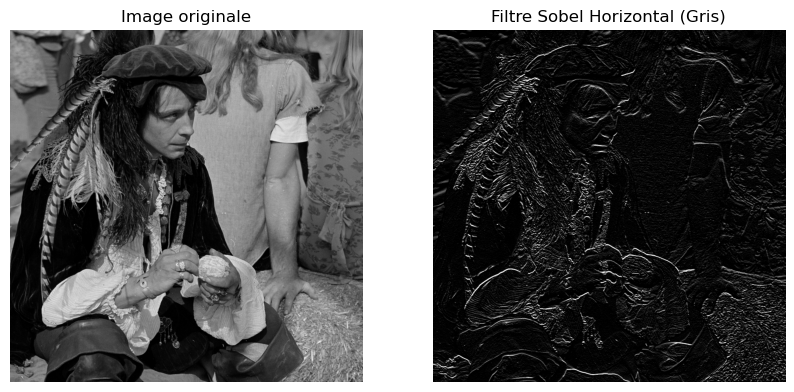

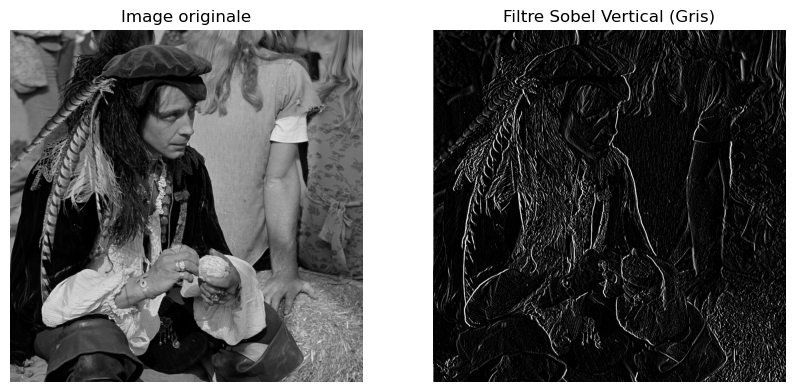

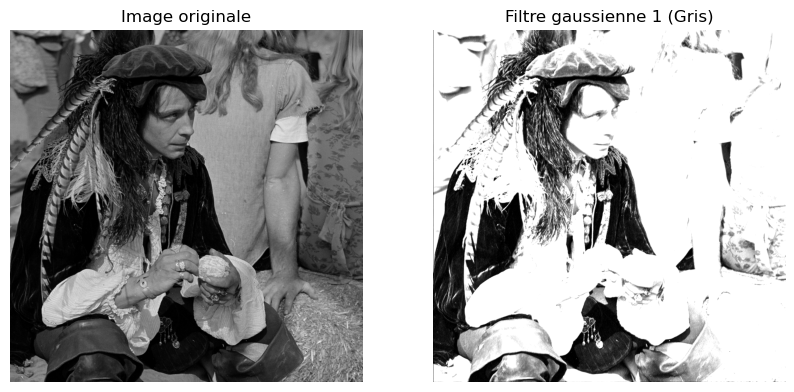

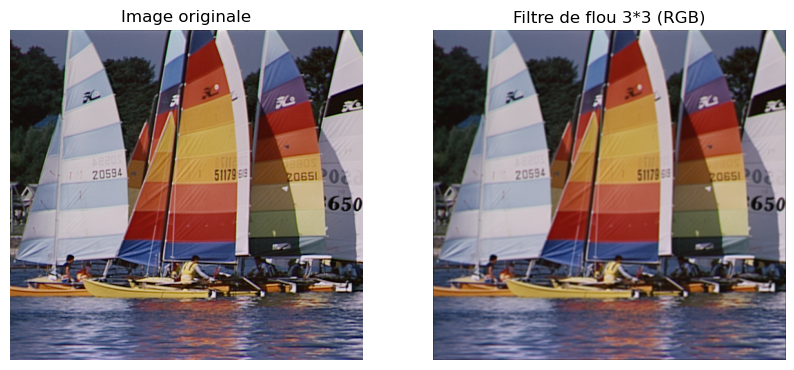

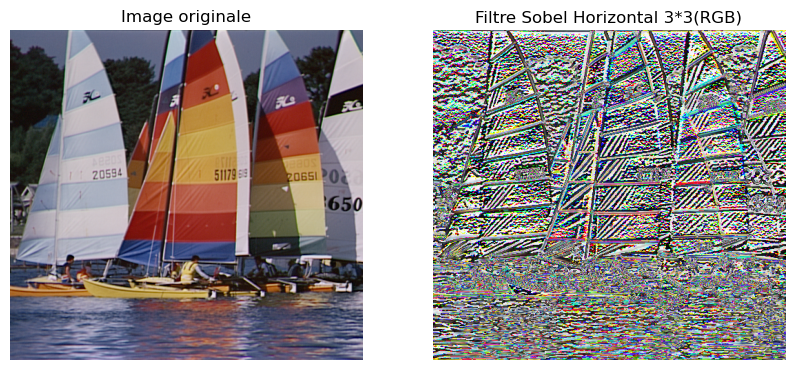

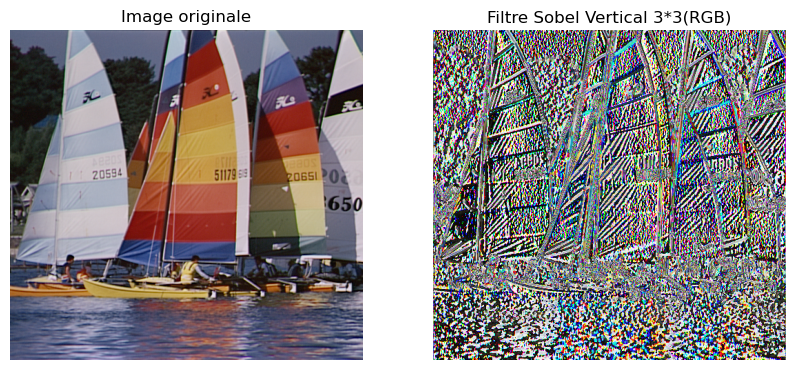

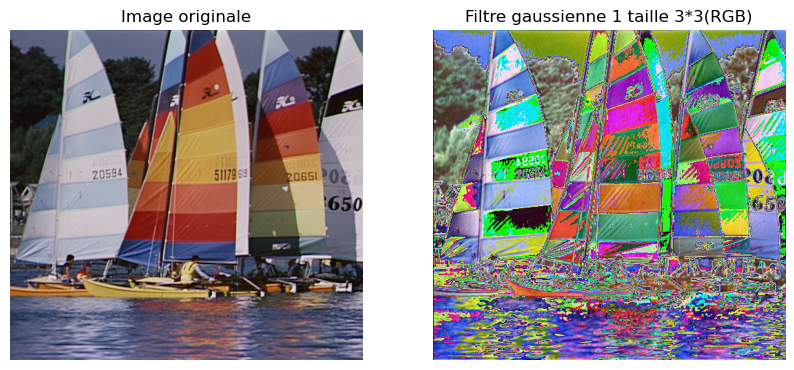

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt  # Missing import

# Load images
gray_image = cv2.imread(r"C:\Users\user\Downloads\man.bmp", cv2.IMREAD_GRAYSCALE)  # Fixed typo in IMREAD_GRAYSCALE
rgb_image = cv2.imread(r"C:\Users\user\Downloads\yacht.bmp") 
rgb_image = rgb_image[:,:,::-1]

# Check if images are loaded correctly
if gray_image is None:
    raise ValueError("Failed to load gray image (1.png)")
if rgb_image is None:
    raise ValueError("Failed to load RGB image (12.png)")

def convolve_channel(image, kernel):
    # Calculate padding size based on kernel (generalized for any kernel size)
    pad_size = kernel.shape[0] // 2
    padded = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant', constant_values=0)
    
    output = np.zeros_like(image, dtype=np.float32)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i, j] = np.sum(padded[i:i+kernel.shape[0], j:j+kernel.shape[1]] * kernel)
    return output

def apply_convolution(image, kernel):
    # Input validation
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy"
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy"
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D"
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré"
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire"

    if len(image.shape) == 3:  # Image RGB
        output = np.zeros_like(image)
        for c in range(image.shape[2]):
            output[:, :, c] = convolve_channel(image[:, :, c], kernel)
    else:  # Image grise
        output = convolve_channel(image, kernel)
    return np.clip(output, 0, 255).astype(np.uint8)

def display_images(original, filtered, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image originale")
    plt.imshow(original, cmap='gray' if len(original.shape) == 2 else None)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(filtered, cmap='gray' if len(filtered.shape) == 2 else None)
    plt.axis('off')
    plt.show()

# Define kernels
blur_kernel = np.array([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]])
sobel_horizontal = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
sobel_vertical = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # Fixed sobel vertical kernel
np.random.seed(42)
filter_gaussiene = np.random.normal(0, 1, (3, 3))



# Apply convolutions
blurred_gray = apply_convolution(gray_image, blur_kernel)
sobel_h_gray = apply_convolution(gray_image, sobel_horizontal)
sobel_v_gray = apply_convolution(gray_image, sobel_vertical)
filter_gaussiene_gray = apply_convolution(gray_image,filter_gaussiene)


blurred_rgb = apply_convolution(rgb_image, blur_kernel)
sobel_h_rgb = apply_convolution(rgb_image, sobel_horizontal)
sobel_v_rgb = apply_convolution(rgb_image, sobel_vertical)
filter_gaussiene_rgb = apply_convolution(rgb_image, filter_gaussiene)


# Display results
display_images(gray_image, blurred_gray, "Filtre de flou 3*3 (Gris)")
display_images(gray_image, sobel_h_gray, "Filtre Sobel Horizontal (Gris)")
display_images(gray_image, sobel_v_gray, "Filtre Sobel Vertical (Gris)")
display_images(gray_image, filter_gaussiene_gray, "Filtre gaussienne 1 (Gris)")



display_images(rgb_image, blurred_rgb, "Filtre de flou 3*3 (RGB)")

display_images(rgb_image, sobel_h_rgb, "Filtre Sobel Horizontal 3*3(RGB)")
display_images(rgb_image, sobel_v_rgb, "Filtre Sobel Vertical 3*3(RGB)")
display_images(rgb_image, filter_gaussiene_rgb, "Filtre gaussienne 1 taille 3*3(RGB)")

